In [1]:
!pip install torchtext

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset, TensorDataset, Dataset, random_split
from torchvision import datasets, transforms
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
import re
from PIL import Image
import time
from nltk.tokenize import sent_tokenize, word_tokenize 
import nltk
from nltk.corpus import stopwords
from torch.utils.data.dataloader import default_collate
from nltk.stem import WordNetLemmatizer
import string
from tqdm import tqdm
import gc

/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <32D95B5B-8DE9-3BF9-9415-0B11B00E776F> /Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <ED5B7495-D9A3-3875-A01B-C86976E4F5BB> /Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/radhikasingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/radhikasingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
df = pd.read_csv(r'Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.shape

(14640, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
df.isna().sum() * 100/ len(df) 

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

columns negativereason_gold , tweet_coord have mostly nan values, not adding meaning to the dataset. therefore, will not be included in the feature set

In [9]:
df['negativereason'].head(10)

0           NaN
1           NaN
2           NaN
3    Bad Flight
4    Can't Tell
5    Can't Tell
6           NaN
7           NaN
8           NaN
9           NaN
Name: negativereason, dtype: object

In [10]:
df['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [11]:
df.loc[df['negativereason'].isna(), 'airline_sentiment'].unique()

array(['neutral', 'positive'], dtype=object)

The columns having nan negative reason either have positve or negative senitment analysis. thus we will map the value to 0 and not remove the column

In [12]:
negative_reason_mapped={'Bad Flight':1, "Can't Tell":2, 'Late Flight':3,'Customer Service Issue':4, 
                 'Flight Booking Problems':5,'Lost Luggage':6, 'Flight Attendant Complaints':7, 
                 'Cancelled Flight':8,'Damaged Luggage':9, 'longlines':10}
df['negative_reason_mapped']=df['negativereason'].apply(lambda x:negative_reason_mapped.get(x,0))

In [13]:
df['negative_reason_mapped'].head()

0    0
1    0
2    0
3    1
4    2
Name: negative_reason_mapped, dtype: int64

In [14]:
df['negative_reason_mapped'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [15]:
airline_sentiment_mapped = {'positive':0,'neutral':1,'negative':2}
df['airline_sentiment_mapped']=df['airline_sentiment'].apply(lambda x:airline_sentiment_mapped.get(x,'Unknown'))

In [16]:
df['airline_sentiment_mapped'].head()

0    1
1    0
2    1
3    2
4    2
Name: airline_sentiment_mapped, dtype: int64

In [17]:
df['user_timezone']=df['user_timezone'].str.lower()

In [18]:
df['user_timezone'].unique()

array(['eastern time (us & canada)', 'pacific time (us & canada)',
       'central time (us & canada)', 'america/new_york',
       'atlantic time (canada)', 'quito', nan,
       'mountain time (us & canada)', 'vienna', 'caracas', 'kuala lumpur',
       'brisbane', 'arizona', 'london', 'tehran', 'alaska', 'sydney',
       'irkutsk', 'santiago', 'amsterdam', 'tijuana', 'abu dhabi',
       'central america', 'edinburgh', 'jerusalem', 'hawaii', 'paris',
       'guam', 'new delhi', 'stockholm', 'america/chicago', 'berlin',
       'madrid', 'athens', 'brussels', 'taipei', 'rome', 'beijing',
       'mexico city', 'bern', 'singapore', 'indiana (east)', 'melbourne',
       'saskatchewan', 'casablanca', 'brasilia', 'kyiv', 'bucharest',
       'greenland', 'prague', 'new caledonia', 'bogota', 'seoul',
       'sarajevo', 'wellington', 'bangkok', 'warsaw', 'copenhagen',
       'hong kong', 'guadalajara', 'mid-atlantic', 'mazatlan',
       'buenos aires', 'america/los_angeles', 'dublin', 'lisbon',
 

In [19]:
user_timezone_mapped={'eastern time (us & canada)':1, 'pacific time (us & canada)':2,'central time (us & canada)':3,
'america/new_york':4,'atlantic time (canada)':5, 'quito':6,'mountain time (us & canada)':6, 'vienna':7, 'caracas':8,
'kuala lumpur':9,'brisbane':10, 'arizona':11, 'london':12, 'tehran':13, 'alaska':14, 'sydney':15,'irkutsk':16, 
'santiago':17, 'amsterdam':18, 'tijuana':19, 'abu dhabi':20,'central america':21, 'edinburgh':22, 'jerusalem':23,
'hawaii':24, 'paris':25, 'guam':26, 'new delhi':27, 'stockholm':28, 'america/chicago':29, 'berlin':30,'madrid':31, 
'athens':32, 'brussels':33, 'taipei':34, 'rome':35, 'beijing':36,'mexico city':37, 'bern':38, 'singapore':39, 
'indiana (east)':40, 'melbourne':41,'saskatchewan':42, 'casablanca':43, 'brasilia':44, 'kyiv':45, 'bucharest':46,
       'greenland':47, 'prague':48, 'new caledonia':49, 'bogota':50, 'seoul':51,
       'sarajevo':52, 'wellington':53, 'bangkok':54, 'warsaw':55, 'copenhagen':56,
       'hong kong':57, 'guadalajara':58, 'mid-atlantic':59, 'mazatlan':60,
       'buenos aires':61, 'america/los_angeles':62, 'dublin':63, 'lisbon':64,
       'newfoundland':65, 'monterrey':66, 'tokyo':67, 'america/detroit':68,
       'midway island':69, 'istanbul':70, 'solomon is.':71, 'america/atikokan':72,
       'adelaide':73, 'nairobi':74, 'est':75, 'lima':76, 'islamabad':77, 'helsinki':78,
       'pretoria':79, 'west central africa':80, 'america/boise':81, 'canberra':82,'perth':83, 'la paz':84}


In [20]:
df['user_timezone_mapped']=df['user_timezone'].apply(lambda x:user_timezone_mapped.get(x,0))

In [21]:
df.loc[df['negativereason_confidence'].isna(), 'airline_sentiment'].unique()

array(['neutral', 'positive'], dtype=object)

In [22]:
df['negativereason_confidence'].fillna(0)

0        0.0000
1        0.0000
2        0.0000
3        0.7033
4        1.0000
          ...  
14635    0.0000
14636    1.0000
14637    0.0000
14638    0.6659
14639    0.0000
Name: negativereason_confidence, Length: 14640, dtype: float64

In [23]:
df[['tweet_location','user_timezone']]

,tweet_location,user_timezone
0,NaN,eastern time (us & canada)
1,NaN,pacific time (us & canada)
2,Lets Play,central time (us & canada)
3,NaN,pacific time (us & canada)
4,NaN,pacific time (us & canada)
...,...,...
14635,NaN,NaN
14636,Texas,NaN
14637,"Nigeria,lagos",NaN
14638,New Jersey,eastern time (us & canada)


The columns tweet_location and user_timezone have same literal meanings. Therefore the mapped version of user-timezone would be used as it has general values which makes an easy feature

In [24]:
df['text'].head(10)

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
7    @VirginAmerica Really missed a prime opportuni...
8      @virginamerica Well, I didn't…but NOW I DO! :-D
9    @VirginAmerica it was amazing, and arrived an ...
Name: text, dtype: object

In [25]:
def stopwords_removal(text):
    words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    t = [w for w in tokens if w.lower() not in words]
    t = ' '.join(t)
    t = re.sub(r'[^A-Za-z\s]', ' ', t) 
    t = re.sub(r'\s+', ' ', t) 
    t = t.strip() 
    return ''.join(t)
df['clean_text']=df['text'].apply(lambda x:stopwords_removal(x))
df['clean_text'].head()

0                          VirginAmerica dhepburn said
1    VirginAmerica plus ve added commercials experi...
2    VirginAmerica n t today Must mean need take an...
3    VirginAmerica s really aggressive blast obnoxi...
4                 VirginAmerica s really big bad thing
Name: clean_text, dtype: object

In [26]:
w2i, i2w, wc, seq = {},{}, 0, []


for t in df['clean_text']:
    tks = word_tokenize(t)
    s = []  
    for tk in tks:
        if tk not in w2i:
            w2i[tk] = wc
            i2w[wc] = tk
            wc += 1
        s.append(w2i[tk])  
    seq.append(s)  


df['sequences'] = seq
df['sequences'].head()

0                                          [0, 1, 2]
1                              [0, 3, 4, 5, 6, 7, 8]
2             [0, 9, 10, 11, 12, 13, 14, 15, 16, 17]
3    [0, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
4                            [0, 18, 19, 29, 30, 31]
Name: sequences, dtype: object

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [28]:
df['airline_sentiment_confidence'].describe()

count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

<Axes: xlabel='negative_reason_mapped'>

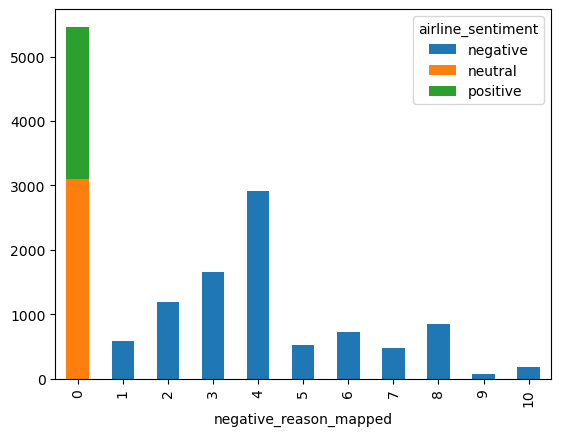

In [29]:
plot_data = df.groupby(["negative_reason_mapped", "airline_sentiment"]).size().unstack()
plot_data.plot(kind="bar", stacked=True)

In [30]:
plt.figure(figsize=(200, 86))
sns.countplot(data=df, x='user_timezone_mapped')
plt.xlabel('User Time Zone Tweets')
plt.ylabel('Count')
plt.show()

In [31]:
df['name']=df['name'].str.lower()

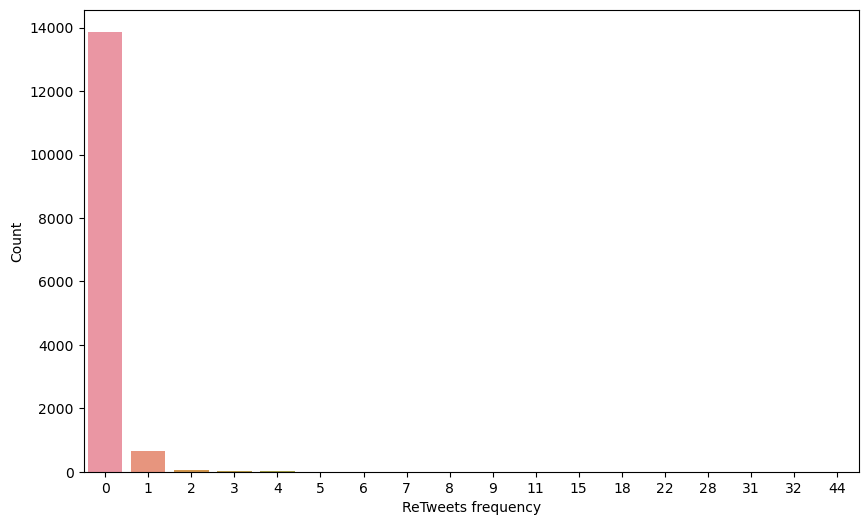

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='retweet_count')
plt.xlabel('ReTweets frequency')
plt.ylabel('Count')
plt.show()

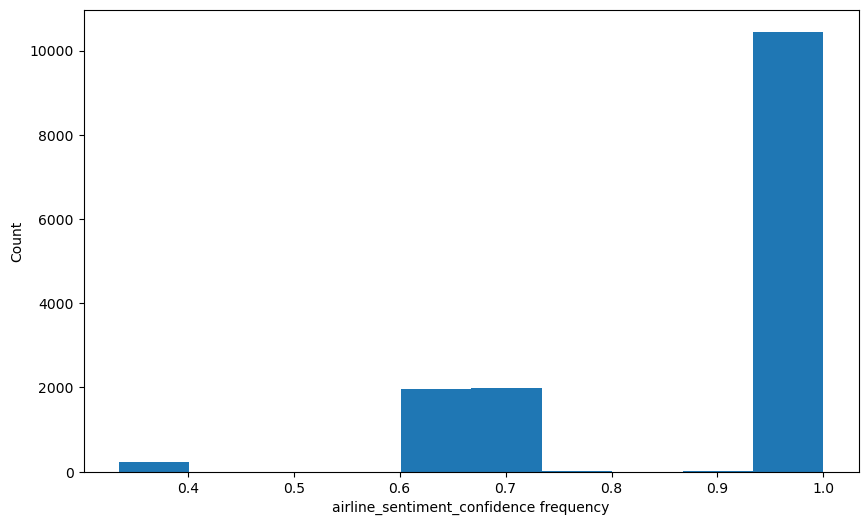

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(data=df, x='airline_sentiment_confidence')
plt.xlabel('airline_sentiment_confidence frequency')
plt.ylabel('Count')
plt.show()

<Axes: >

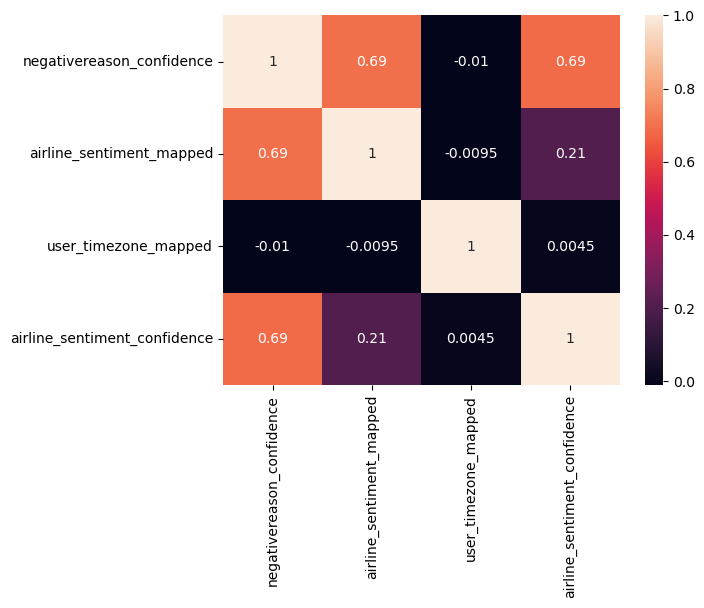

In [34]:
x=df[['negativereason_confidence','airline_sentiment_mapped','user_timezone_mapped','airline_sentiment_confidence']]
x=x.corr()
sns.heatmap(x,annot=True)

In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(t):
    t = t.lower()
    t = ''.join([c for c in t if c not in string.punctuation])
    tk = word_tokenize(t)
    tk = [lemmatizer.lemmatize(w) for w in tk if w not in stop_words]
    return tk

df['clean_text'] = df['text'].apply(preprocess_text)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['airline_sentiment_mapped'], test_size=0.3, random_state=42)
X_test,X_val, y_test, y_val = train_test_split(df['clean_text'],df['airline_sentiment_mapped'], test_size=0.5, random_state=42)

In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10248,), (10248,), (7320,), (7320,))

In [37]:
w2i = {}
i2w = {}
for index, word in enumerate(set(word for sentence in X_train for word in sentence)):
    w2i[word] = index
    i2w[index] = word

In [38]:
class AirlineDataset(Dataset):
    def __init__(self, X, y, max_len):
        self.X = X
        self.y = y
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        tkns = self.X.iloc[idx][:self.max_len]
        indexed_tkns = [w2i[w] for w in tkns if w in w2i][:self.max_len]  
        padded_tkns = indexed_tkns + [0] * (self.max_len - len(indexed_tkns))  
        padded_tkns_np = np.array(padded_tkns, dtype=np.int64) 
        lbl_np = np.array(self.y.iloc[idx], dtype=np.int64) 
        return torch.tensor(padded_tkns_np), torch.tensor(lbl_np)

In [39]:
max_len = max(len(s) for s in X_train)
train_dataset = AirlineDataset(X_train, y_train, max_len)
val_dataset = AirlineDataset(X_val, y_val, max_len)
test_dataset = AirlineDataset(X_test, y_test, max_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=3):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output


vocab_size = len(w2i)
embedding_dim = 100
hidden_dim = 256
output_dim = 3 
lstm_model_one = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
lstm_model_one.to(device)

LSTM(
  (embedding): Embedding(12862, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [41]:
lstm_time,lstm_train_acc_one,lstm_val_acc_one,lstm_test_acc_one,lstm_train_loss_one,lstm_test_loss_one,lstm_val_loss_one=[],[],[],[],[],[],[]
num_epochs = 10
lstm_true_labels_one = []
lstm_pred_labels_one = []
start_time=time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model_one.parameters(), lr=0.001)



for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0
    lstm_model_one.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model_one(inputs)
        #outputs = output.to(device)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct / total * 100}%")
    lstm_train_acc_one.append(correct / total * 100)
    lstm_train_loss_one.append(running_loss / len(train_loader))
    
    lstm_model_one.eval()
    val_loss, val_correct, val_total  = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model_one(inputs)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            del inputs, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy * 100}%")
    lstm_val_acc_one.append(val_accuracy*100)
    lstm_val_loss_one.append(avg_val_loss)
    

    
lstm_model_one.eval()
test_loss,test_correct,test_total = 0.0, 0, 0
with torch.no_grad():
    for batch in test_loader:
        features, labels = batch[0].to(device), batch[1].to(device)
        outputs = lstm_model_one(features)
        #outputs = output.to(device)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        lstm_true_labels_one.extend(labels.cpu().numpy())
        lstm_pred_labels_one.extend(predicted.cpu().numpy())
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy * 100}%")
lstm_test_acc_one.append(test_accuracy)
lstm_test_loss_one.append(avg_test_loss)
    

end_time=time.time()
lstm_time.append(end_time-start_time)

100%|█████████████████████████████████████████| 321/321 [00:59<00:00,  5.39it/s]


Epoch 1, Loss: 0.8956760331477703, Accuracy: 62.168227946916474%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.11it/s]


Validation Loss: 0.8453224301338196, Accuracy: 63.97540983606558%


100%|█████████████████████████████████████████| 321/321 [01:16<00:00,  4.18it/s]


Epoch 2, Loss: 0.772780056033179, Accuracy: 65.33957845433255%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.83it/s]


Validation Loss: 0.6861459612846375, Accuracy: 69.31693989071039%


100%|█████████████████████████████████████████| 321/321 [00:59<00:00,  5.35it/s]


Epoch 3, Loss: 0.6427879918401487, Accuracy: 73.13622170179546%


100%|█████████████████████████████████████████| 229/229 [00:38<00:00,  5.94it/s]


Validation Loss: 0.5968073606491089, Accuracy: 75.92896174863388%


100%|█████████████████████████████████████████| 321/321 [00:58<00:00,  5.49it/s]


Epoch 4, Loss: 0.52531097833984, Accuracy: 78.94223263075723%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.14it/s]


Validation Loss: 0.3736340403556824, Accuracy: 78.67486338797815%


100%|█████████████████████████████████████████| 321/321 [00:59<00:00,  5.38it/s]


Epoch 5, Loss: 0.41662145009107676, Accuracy: 84.192037470726%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.19it/s]


Validation Loss: 0.21380704641342163, Accuracy: 80.86065573770492%


100%|█████████████████████████████████████████| 321/321 [01:00<00:00,  5.32it/s]


Epoch 6, Loss: 0.31612846139249773, Accuracy: 88.92466822794691%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.05it/s]


Validation Loss: 0.36727374792099, Accuracy: 82.5%


100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.16it/s]


Epoch 7, Loss: 0.22198264089027112, Accuracy: 92.99375487900078%


100%|█████████████████████████████████████████| 229/229 [00:38<00:00,  5.98it/s]


Validation Loss: 0.0563933327794075, Accuracy: 83.27868852459017%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.56it/s]


Epoch 8, Loss: 0.16961766202350922, Accuracy: 94.91608118657298%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.26it/s]


Validation Loss: 0.14405888319015503, Accuracy: 83.7431693989071%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.56it/s]


Epoch 9, Loss: 0.12798252668249133, Accuracy: 96.33099141295862%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.14it/s]


Validation Loss: 0.028643690049648285, Accuracy: 84.35792349726776%


100%|█████████████████████████████████████████| 321/321 [00:58<00:00,  5.52it/s]


Epoch 10, Loss: 0.09971775801277885, Accuracy: 97.5312256049961%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.08it/s]


Validation Loss: 0.020781967788934708, Accuracy: 84.48087431693989%
Test Loss: 0.08550561358948852, Accuracy: 97.97814207650273%


In [42]:
summary(lstm_model_one)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─Embedding: 1-1                         1,286,200
├─LSTM: 1-2                              1,419,264
├─Linear: 1-3                            771
Total params: 2,706,235
Trainable params: 2,706,235
Non-trainable params: 0

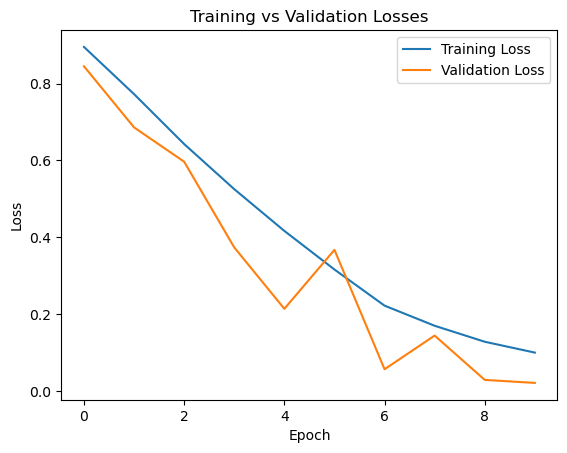

In [43]:
plt.plot(lstm_train_loss_one, label='Training Loss')
plt.plot(lstm_val_loss_one, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

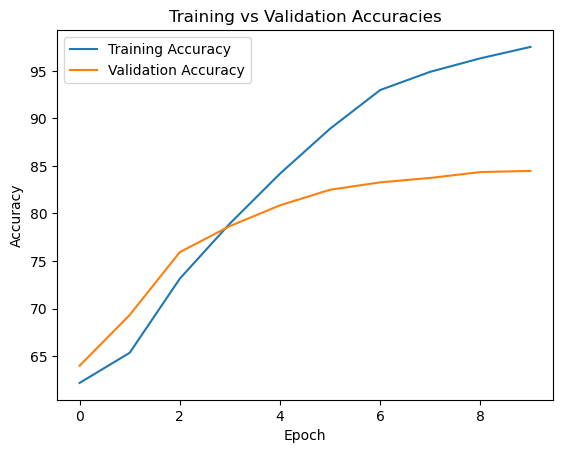

In [44]:
plt.plot(lstm_train_acc_one, label='Training Accuracy')
plt.plot(lstm_val_acc_one, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

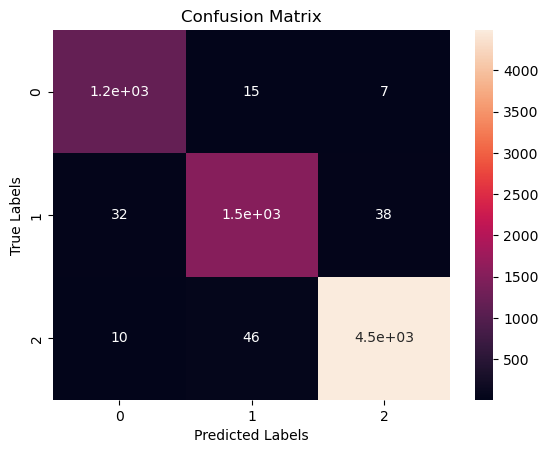

In [45]:
conf_matrix = confusion_matrix(lstm_true_labels_one, lstm_pred_labels_one)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
precision = precision_score(lstm_true_labels_one, lstm_pred_labels_one, average = 'macro')
recall = recall_score(lstm_true_labels_one, lstm_pred_labels_one, average = 'macro')
f1 = f1_score(lstm_true_labels_one, lstm_pred_labels_one, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.97, Recall: 0.98, F1 Score: 0.97


# Hyperparameters 1 -hidden dim = 128, no of layers-6, epochs-15

In [47]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=6):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

vocab_size = len(w2i)
embedding_dim = 100
hidden_dim = 128
output_dim = 3 
lstm_model_two = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
lstm_model_two.to(device)

LSTM(
  (embedding): Embedding(12862, 100)
  (lstm): LSTM(100, 128, num_layers=6, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [48]:
lstm_time,lstm_train_acc_two,lstm_val_acc_two,lstm_test_acc_two,lstm_train_loss_two,lstm_test_loss_two,lstm_val_loss_two=[],[],[],[],[],[],[]
num_epochs = 20
lstm_true_labels_two = []
lstm_pred_labels_two = []
start_time=time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model_two.parameters(), lr=0.001)



for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0
    lstm_model_two.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model_two(inputs)
        #outputs = output.to(device)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct / total * 100}%")
    lstm_train_acc_two.append(correct / total * 100)
    lstm_train_loss_two.append(running_loss / len(train_loader))
    
    lstm_model_two.eval()
    val_loss, val_correct, val_total  = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model_two(inputs)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            del inputs, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy * 100}%")
    lstm_val_acc_two.append(val_accuracy*100)
    lstm_val_loss_two.append(avg_val_loss)
    
    
    
lstm_model_two.eval()
test_loss,test_correct,test_total = 0.0, 0, 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        features, labels = batch[0].to(device), batch[1].to(device)
        outputs = lstm_model_two(features)
        #outputs = output.to(device)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        lstm_true_labels_two.extend(labels.cpu().numpy())
        lstm_pred_labels_two.extend(predicted.cpu().numpy())
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy * 100}%")
lstm_test_acc_two.append(test_accuracy)
lstm_test_loss_two.append(avg_test_loss)
    

end_time=time.time()
lstm_time.append(end_time-start_time)

100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.11it/s]


Epoch 1, Loss: 0.8264559923302719, Accuracy: 64.07103825136612%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.08it/s]


Validation Loss: 0.5702414512634277, Accuracy: 69.94535519125684%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.08it/s]


Epoch 2, Loss: 0.6878572411811983, Accuracy: 70.84309133489461%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.25it/s]


Validation Loss: 0.5280529856681824, Accuracy: 73.83879781420765%


100%|█████████████████████████████████████████| 321/321 [01:01<00:00,  5.26it/s]


Epoch 3, Loss: 0.5955799080408251, Accuracy: 75.93676814988291%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.18it/s]


Validation Loss: 0.7400799989700317, Accuracy: 77.6639344262295%


100%|█████████████████████████████████████████| 321/321 [01:01<00:00,  5.21it/s]


Epoch 4, Loss: 0.5131769612942157, Accuracy: 80.70843091334895%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.10it/s]


Validation Loss: 0.8187605142593384, Accuracy: 78.90710382513662%


100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.11it/s]


Epoch 5, Loss: 0.43983098117176245, Accuracy: 83.94808743169399%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.21it/s]


Validation Loss: 0.13067571818828583, Accuracy: 80.6967213114754%


100%|█████████████████████████████████████████| 321/321 [01:01<00:00,  5.23it/s]


Epoch 6, Loss: 0.3716247223805044, Accuracy: 87.38290398126463%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.11it/s]


Validation Loss: 0.8689439296722412, Accuracy: 81.87158469945355%


100%|█████████████████████████████████████████| 321/321 [22:42<00:00,  4.24s/it]


Epoch 7, Loss: 0.30611519965798684, Accuracy: 90.09562841530054%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.16it/s]


Validation Loss: 0.09214803576469421, Accuracy: 82.28142076502732%


100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.13it/s]


Epoch 8, Loss: 0.25590192399501244, Accuracy: 92.08626073380172%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.22it/s]


Validation Loss: 0.4386197626590729, Accuracy: 83.25136612021858%


100%|█████████████████████████████████████████| 321/321 [04:35<00:00,  1.16it/s]


Epoch 9, Loss: 0.23060596977995934, Accuracy: 92.75956284153006%


100%|█████████████████████████████████████████| 229/229 [08:51<00:00,  2.32s/it]


Validation Loss: 0.027607765048742294, Accuracy: 83.31967213114754%


100%|█████████████████████████████████████████| 321/321 [23:12<00:00,  4.34s/it]


Epoch 10, Loss: 0.18903302343277917, Accuracy: 94.42818110850898%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.10it/s]


Validation Loss: 0.5714080333709717, Accuracy: 84.04371584699454%


100%|█████████████████████████████████████████| 321/321 [01:06<00:00,  4.83it/s]


Epoch 11, Loss: 0.16249995124221683, Accuracy: 95.4527712724434%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.07it/s]


Validation Loss: 0.37106752395629883, Accuracy: 84.18032786885246%


100%|█████████████████████████████████████████| 321/321 [01:01<00:00,  5.20it/s]


Epoch 12, Loss: 0.1479924828904997, Accuracy: 95.96018735362998%


100%|█████████████████████████████████████████| 229/229 [00:40<00:00,  5.62it/s]


Validation Loss: 0.014844822697341442, Accuracy: 83.86612021857923%


100%|█████████████████████████████████████████| 321/321 [01:10<00:00,  4.53it/s]


Epoch 13, Loss: 0.13491844059754385, Accuracy: 96.13583138173301%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.78it/s]


Validation Loss: 0.013205920346081257, Accuracy: 83.86612021857923%


100%|█████████████████████████████████████████| 321/321 [01:18<00:00,  4.07it/s]


Epoch 14, Loss: 0.1192212719383223, Accuracy: 96.7408274785324%


100%|█████████████████████████████████████████| 229/229 [00:41<00:00,  5.46it/s]


Validation Loss: 0.06824277341365814, Accuracy: 84.38524590163935%


100%|█████████████████████████████████████████| 321/321 [01:40<00:00,  3.18it/s]


Epoch 15, Loss: 0.09917645350771716, Accuracy: 97.47267759562843%


100%|█████████████████████████████████████████| 229/229 [01:00<00:00,  3.77it/s]


Validation Loss: 0.007200269959867001, Accuracy: 84.37158469945355%


100%|█████████████████████████████████████████| 321/321 [01:08<00:00,  4.66it/s]


Epoch 16, Loss: 0.08603143917158756, Accuracy: 97.93130366900859%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.87it/s]


Validation Loss: 0.37147876620292664, Accuracy: 84.8360655737705%


100%|█████████████████████████████████████████| 321/321 [01:04<00:00,  4.97it/s]


Epoch 17, Loss: 0.08424007406202942, Accuracy: 97.97033567525371%


100%|█████████████████████████████████████████| 229/229 [00:40<00:00,  5.72it/s]


Validation Loss: 0.010730862617492676, Accuracy: 84.33060109289617%


100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.15it/s]


Epoch 18, Loss: 0.08712584246675313, Accuracy: 97.81420765027322%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.08it/s]


Validation Loss: 0.047125741839408875, Accuracy: 84.49453551912568%


100%|█████████████████████████████████████████| 321/321 [04:45<00:00,  1.12it/s]


Epoch 19, Loss: 0.08859254827003381, Accuracy: 97.5800156128025%


100%|█████████████████████████████████████████| 229/229 [00:42<00:00,  5.43it/s]


Validation Loss: 0.012441698461771011, Accuracy: 85.13661202185793%


100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.13it/s]


Epoch 20, Loss: 0.08533875318969429, Accuracy: 97.75565964090555%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.11it/s]


Validation Loss: 0.03991463780403137, Accuracy: 84.60382513661202%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.12it/s]

Test Loss: 0.06573796264347356, Accuracy: 98.3879781420765%


In [49]:
summary(lstm_model_two)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─Embedding: 1-1                         1,286,200
├─LSTM: 1-2                              778,240
├─Linear: 1-3                            387
Total params: 2,064,827
Trainable params: 2,064,827
Non-trainable params: 0

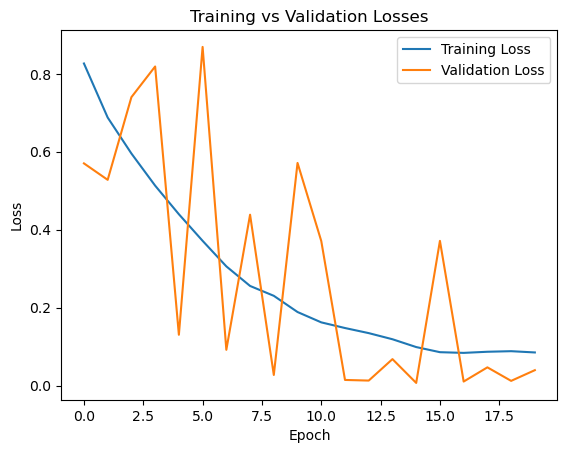

In [50]:
plt.plot(lstm_train_loss_two, label='Training Loss')
plt.plot(lstm_val_loss_two, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

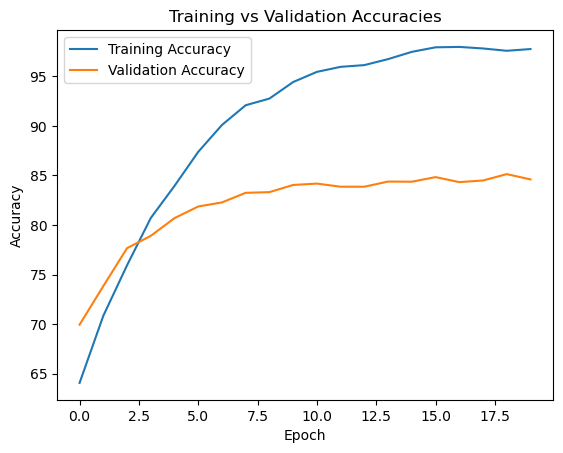

In [51]:
plt.plot(lstm_train_acc_two, label='Training Accuracy')
plt.plot(lstm_val_acc_two, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

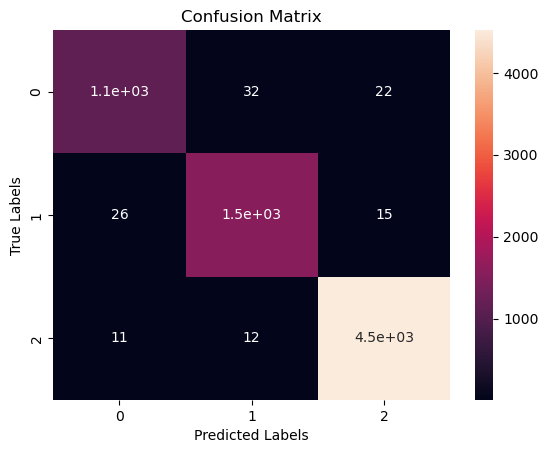

In [52]:
conf_matrix = confusion_matrix(lstm_true_labels_two, lstm_pred_labels_two)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [53]:
precision = precision_score(lstm_true_labels_two, lstm_pred_labels_two, average = 'macro')
recall = recall_score(lstm_true_labels_two, lstm_pred_labels_two, average = 'macro')
f1 = f1_score(lstm_true_labels_two, lstm_pred_labels_two, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.98, Recall: 0.97, F1 Score: 0.98


In [54]:
torch.save(lstm_model_two.state_dict(), 'rsingh57_ts92_assignment1_part_4_lstm_best_model.h5')

## ImprovedLSTM -  Bidirectional LSTM

In [55]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=3):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        hidden = torch.cat((output[:, -1, :hidden_dim], output[:, 0, hidden_dim:]), dim=1)
        return self.fc(hidden)


vocab_size = len(w2i)
embedding_dim = 100
hidden_dim = 256
output_dim = 3 
bi_lstm_model_one = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
bi_lstm_model_one.to(device)

BiLSTM(
  (embedding): Embedding(12862, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [56]:
bi_lstm_time,bi_lstm_train_acc_one,bi_lstm_val_acc_one,bi_lstm_test_acc_one,bi_lstm_train_loss_one,bi_lstm_test_loss_one,bi_lstm_val_loss_one=[],[],[],[],[],[],[]
num_epochs = 10
bi_lstm_true_labels_one = []
bi_lstm_pred_labels_one = []
start_time=time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bi_lstm_model_one.parameters(), lr=0.001)

bi_lstm_model_one.to(device)

for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0
    bi_lstm_model_one.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = bi_lstm_model_one(inputs)
        #outputs = output.to(device)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct / total * 100}%")
    bi_lstm_train_acc_one.append(correct / total * 100)
    bi_lstm_train_loss_one.append(running_loss / len(train_loader))
    
    bi_lstm_model_one.eval()
    val_loss, val_correct, val_total  = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = bi_lstm_model_one(inputs)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            del inputs, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy * 100}%")
    bi_lstm_val_acc_one.append(val_accuracy*100)
    bi_lstm_val_loss_one.append(avg_val_loss)
    
bi_lstm_model_one.eval()
test_loss,test_correct,test_total = 0.0, 0, 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        features, labels = batch[0].to(device), batch[1].to(device)
        outputs = bi_lstm_model_one(features)
        #outputs = output.to(device)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        bi_lstm_true_labels_one.extend(labels.cpu().numpy())
        bi_lstm_pred_labels_one.extend(predicted.cpu().numpy())
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy * 100}%")
bi_lstm_test_acc_one.append(test_accuracy)
bi_lstm_test_loss_one.append(avg_test_loss)
    

end_time=time.time()
bi_lstm_time.append(end_time-start_time)

100%|█████████████████████████████████████████| 321/321 [01:05<00:00,  4.88it/s]


Epoch 1, Loss: 0.7381783062795241, Accuracy: 69.34035909445745%


100%|█████████████████████████████████████████| 229/229 [00:40<00:00,  5.67it/s]


Validation Loss: 1.3391032218933105, Accuracy: 74.1256830601093%


100%|█████████████████████████████████████████| 321/321 [01:05<00:00,  4.94it/s]


Epoch 2, Loss: 0.5870660604717576, Accuracy: 76.51249024199845%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.84it/s]


Validation Loss: 0.7767192125320435, Accuracy: 78.63387978142077%


100%|█████████████████████████████████████████| 321/321 [01:04<00:00,  5.00it/s]


Epoch 3, Loss: 0.4709549439937526, Accuracy: 81.58665105386417%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.81it/s]


Validation Loss: 0.480243057012558, Accuracy: 81.2568306010929%


100%|█████████████████████████████████████████| 321/321 [01:04<00:00,  4.97it/s]


Epoch 4, Loss: 0.3564512018938302, Accuracy: 86.85597189695551%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.80it/s]


Validation Loss: 0.4661984443664551, Accuracy: 82.8551912568306%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.04it/s]


Epoch 5, Loss: 0.2554163277218832, Accuracy: 90.94457455113194%


100%|█████████████████████████████████████████| 229/229 [00:40<00:00,  5.71it/s]


Validation Loss: 0.2637932598590851, Accuracy: 84.33060109289617%


100%|█████████████████████████████████████████| 321/321 [01:04<00:00,  4.99it/s]


Epoch 6, Loss: 0.17364717824993847, Accuracy: 94.14519906323186%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.80it/s]


Validation Loss: 0.10206817090511322, Accuracy: 84.8360655737705%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.03it/s]


Epoch 7, Loss: 0.11005924162933621, Accuracy: 96.53590944574552%


100%|█████████████████████████████████████████| 229/229 [00:38<00:00,  5.90it/s]


Validation Loss: 0.001559976488351822, Accuracy: 84.8224043715847%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.04it/s]


Epoch 8, Loss: 0.07596930901801383, Accuracy: 97.65807962529274%


100%|█████████████████████████████████████████| 229/229 [00:51<00:00,  4.46it/s]


Validation Loss: 0.008049334399402142, Accuracy: 85.46448087431693%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.03it/s]


Epoch 9, Loss: 0.0645429871554234, Accuracy: 97.98985167837627%


100%|█████████████████████████████████████████| 229/229 [00:38<00:00,  5.88it/s]


Validation Loss: 0.09563028812408447, Accuracy: 85.12295081967213%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.06it/s]


Epoch 10, Loss: 0.05394571563018619, Accuracy: 98.19476971116316%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.84it/s]


Validation Loss: 0.0017702499171718955, Accuracy: 84.49453551912568%


100%|█████████████████████████████████████████| 229/229 [00:39<00:00,  5.79it/s]

Test Loss: 0.04772304922980805, Accuracy: 98.45628415300547%


In [57]:
summary(bi_lstm_model_one)

Layer (type:depth-idx)                   Param #
BiLSTM                                   --
├─Embedding: 1-1                         1,286,200
├─LSTM: 1-2                              3,887,104
├─Linear: 1-3                            1,539
Total params: 5,174,843
Trainable params: 5,174,843
Non-trainable params: 0

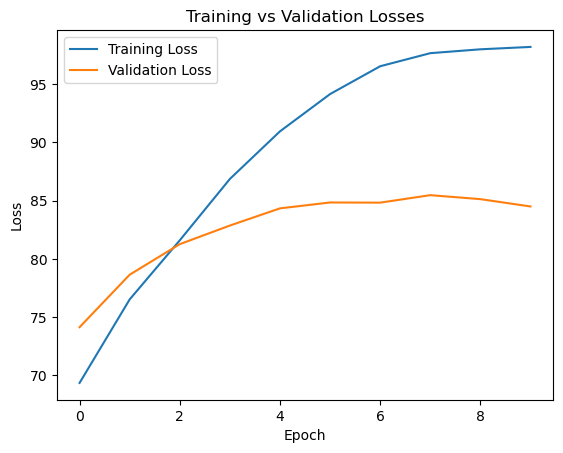

In [58]:
plt.plot(bi_lstm_train_acc_one, label='Training Loss')
plt.plot(bi_lstm_val_acc_one, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

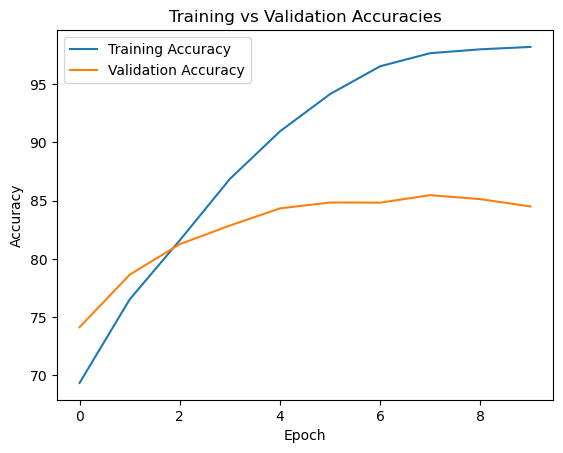

In [59]:
plt.plot(bi_lstm_train_acc_one, label='Training Accuracy')
plt.plot(bi_lstm_val_acc_one, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

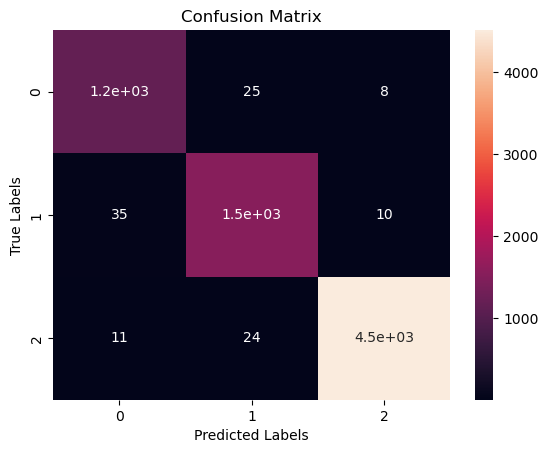

In [60]:
conf_matrix = confusion_matrix(bi_lstm_true_labels_one, bi_lstm_pred_labels_one)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
precision = precision_score(bi_lstm_true_labels_one, bi_lstm_pred_labels_one, average = 'macro')
recall = recall_score(bi_lstm_true_labels_one, bi_lstm_pred_labels_one, average = 'macro')
f1 = f1_score(bi_lstm_true_labels_one, bi_lstm_pred_labels_one, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.98, Recall: 0.98, F1 Score: 0.98


## ImprovedLSTM -  Bidirectional LSTM - Hyperparameter 1 - Dropout, hidden_dim=128, epochs-15

In [62]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=3,dropout=0.1):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        hidden = torch.cat((output[:, -1, :hidden_dim], output[:, 0, hidden_dim:]), dim=1)
        return self.fc(hidden)


vocab_size = len(w2i)
embedding_dim = 100
hidden_dim = 128
output_dim = 3 
bi_lstm_model_two = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
bi_lstm_model_two.to(device)

BiLSTM(
  (embedding): Embedding(12862, 100)
  (lstm): LSTM(100, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [63]:
bi_lstm_time,bi_lstm_train_acc_two,bi_lstm_val_acc_two,bi_lstm_test_acc_two,bi_lstm_train_loss_two,bi_lstm_test_loss_two,bi_lstm_val_loss_two=[],[],[],[],[],[],[]
num_epochs = 20
bi_lstm_true_labels_two = []
bi_lstm_pred_labels_two = []
start_time=time.time()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bi_lstm_model_two.parameters(), lr=0.001)



for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0
    bi_lstm_model_two.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = bi_lstm_model_two(inputs)
        #outputs = output.to(device)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct / total * 100}%")
    bi_lstm_train_acc_two.append((correct / total) * 100)
    bi_lstm_train_loss_two.append(running_loss)
    
    bi_lstm_model_two.eval()
    val_loss, val_correct, val_total  = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = bi_lstm_model_two(inputs)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            del inputs, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy * 100}%")
    bi_lstm_val_acc_two.append(val_accuracy*100)
    bi_lstm_val_loss_two.append(avg_val_loss)
    

    
bi_lstm_model_two.eval()
test_loss,test_correct,test_total = 0.0, 0, 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        features, labels = batch[0].to(device), batch[1].to(device)
        outputs = bi_lstm_model_two(features)
        #outputs = output.to(device)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        bi_lstm_true_labels_two.extend(labels.cpu().numpy())
        bi_lstm_pred_labels_two.extend(predicted.cpu().numpy())
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy * 100}%")
bi_lstm_test_acc_two.append(test_accuracy)
bi_lstm_test_loss_two.append(avg_test_loss)
    

end_time=time.time()
bi_lstm_time.append(end_time-start_time)

100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.57it/s]


Epoch 1, Loss: 0.8025395300158088, Accuracy: 65.78844652615145%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.30it/s]


Validation Loss: 0.7354801893234253, Accuracy: 71.27049180327869%


100%|█████████████████████████████████████████| 321/321 [01:03<00:00,  5.09it/s]


Epoch 2, Loss: 0.6440519447267241, Accuracy: 73.73145979703357%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.27it/s]


Validation Loss: 0.7767346501350403, Accuracy: 78.00546448087432%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.62it/s]


Epoch 3, Loss: 0.5362896747028345, Accuracy: 79.41061670569867%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.33it/s]


Validation Loss: 0.3499678075313568, Accuracy: 80.21857923497268%


100%|█████████████████████████████████████████| 321/321 [00:56<00:00,  5.65it/s]


Epoch 4, Loss: 0.42632947956150935, Accuracy: 84.32864949258392%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.31it/s]


Validation Loss: 0.04810943081974983, Accuracy: 81.99453551912569%


100%|█████████████████████████████████████████| 321/321 [01:12<00:00,  4.40it/s]


Epoch 5, Loss: 0.3420648151469008, Accuracy: 87.92935206869633%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.32it/s]


Validation Loss: 0.8134897351264954, Accuracy: 83.04644808743168%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.63it/s]


Epoch 6, Loss: 0.25101758564047727, Accuracy: 91.78376268540202%


100%|█████████████████████████████████████████| 229/229 [01:02<00:00,  3.68it/s]


Validation Loss: 0.38015684485435486, Accuracy: 83.10109289617486%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.63it/s]


Epoch 7, Loss: 0.19238605354898072, Accuracy: 93.70608899297423%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.33it/s]


Validation Loss: 0.07004628330469131, Accuracy: 83.63387978142076%


100%|█████████████████████████████████████████| 321/321 [01:02<00:00,  5.10it/s]


Epoch 8, Loss: 0.13624042849349455, Accuracy: 95.82357533177205%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.10it/s]


Validation Loss: 0.12165523320436478, Accuracy: 83.79781420765028%


100%|█████████████████████████████████████████| 321/321 [00:58<00:00,  5.48it/s]


Epoch 9, Loss: 0.11880924114290149, Accuracy: 96.14558938329431%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.11it/s]


Validation Loss: 0.006310869008302689, Accuracy: 83.33333333333334%


100%|█████████████████████████████████████████| 321/321 [00:59<00:00,  5.44it/s]


Epoch 10, Loss: 0.09499414417765037, Accuracy: 97.17993754879001%


100%|█████████████████████████████████████████| 229/229 [01:08<00:00,  3.32it/s]


Validation Loss: 0.4186968207359314, Accuracy: 83.87978142076503%


100%|█████████████████████████████████████████| 321/321 [00:59<00:00,  5.44it/s]


Epoch 11, Loss: 0.07417466674243735, Accuracy: 97.7263856362217%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.27it/s]


Validation Loss: 0.23829467594623566, Accuracy: 84.05737704918033%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.58it/s]


Epoch 12, Loss: 0.06756852343649461, Accuracy: 97.88251366120218%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.28it/s]


Validation Loss: 0.02281956747174263, Accuracy: 84.13934426229508%


100%|█████████████████████████████████████████| 321/321 [00:58<00:00,  5.51it/s]


Epoch 13, Loss: 0.05632536194281438, Accuracy: 98.28259172521467%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.18it/s]


Validation Loss: 0.008147385902702808, Accuracy: 85.13661202185793%


100%|█████████████████████████████████████████| 321/321 [00:59<00:00,  5.42it/s]


Epoch 14, Loss: 0.052062733486915626, Accuracy: 98.28259172521467%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.23it/s]


Validation Loss: 0.004549882840365171, Accuracy: 84.34426229508196%


100%|█████████████████████████████████████████| 321/321 [01:01<00:00,  5.25it/s]


Epoch 15, Loss: 0.045101462237063995, Accuracy: 98.5167837626854%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.17it/s]


Validation Loss: 0.01142941415309906, Accuracy: 83.83879781420765%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.58it/s]


Epoch 16, Loss: 0.04788396897746795, Accuracy: 98.36065573770492%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.33it/s]


Validation Loss: 0.002097328193485737, Accuracy: 84.23497267759564%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.54it/s]


Epoch 17, Loss: 0.036749991127710525, Accuracy: 98.82903981264637%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.25it/s]


Validation Loss: 0.0016958212945610285, Accuracy: 84.38524590163935%


100%|█████████████████████████████████████████| 321/321 [01:17<00:00,  4.13it/s]


Epoch 18, Loss: 0.03671813266158881, Accuracy: 98.83879781420765%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.26it/s]


Validation Loss: 0.0005634346744045615, Accuracy: 84.03005464480874%


100%|█████████████████████████████████████████| 321/321 [00:57<00:00,  5.56it/s]


Epoch 19, Loss: 0.03903816508367147, Accuracy: 98.63387978142076%


100%|█████████████████████████████████████████| 229/229 [00:38<00:00,  6.01it/s]


Validation Loss: 0.004691098351031542, Accuracy: 84.1256830601093%


100%|█████████████████████████████████████████| 321/321 [00:58<00:00,  5.51it/s]


Epoch 20, Loss: 0.03746598210284411, Accuracy: 98.63387978142076%


100%|█████████████████████████████████████████| 229/229 [00:36<00:00,  6.32it/s]


Validation Loss: 0.0034663460683077574, Accuracy: 84.15300546448088%


100%|█████████████████████████████████████████| 229/229 [00:37<00:00,  6.08it/s]

Test Loss: 0.02493218687392454, Accuracy: 99.30327868852459%


In [64]:
summary(bi_lstm_model_two)

Layer (type:depth-idx)                   Param #
BiLSTM                                   --
├─Embedding: 1-1                         1,286,200
├─LSTM: 1-2                              381,952
├─Linear: 1-3                            387
Total params: 1,668,539
Trainable params: 1,668,539
Non-trainable params: 0

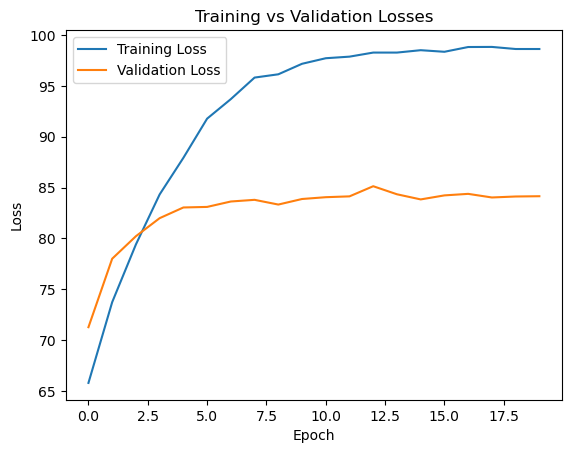

In [65]:
plt.plot(bi_lstm_train_acc_two, label='Training Loss')
plt.plot(bi_lstm_val_acc_two, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

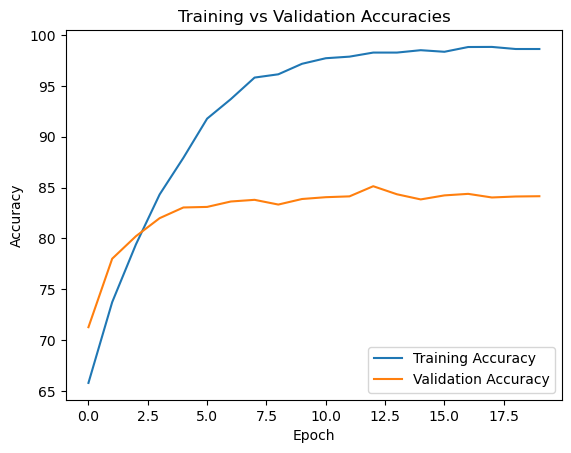

In [66]:
plt.plot(bi_lstm_train_acc_two, label='Training Accuracy')
plt.plot(bi_lstm_val_acc_two, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

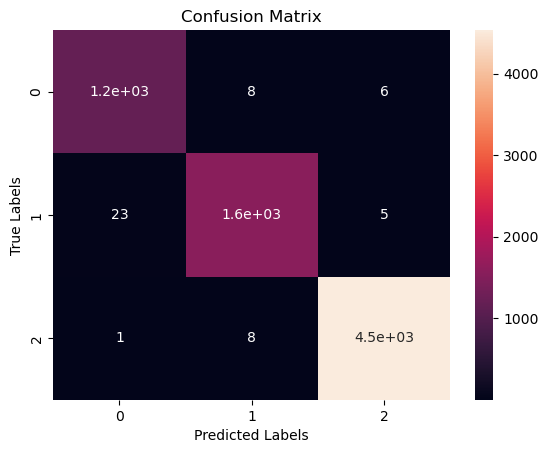

In [67]:
conf_matrix = confusion_matrix(bi_lstm_true_labels_two, bi_lstm_pred_labels_two)
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [68]:
precision = precision_score(bi_lstm_true_labels_two, bi_lstm_pred_labels_two, average = 'macro')
recall = recall_score(bi_lstm_true_labels_two, bi_lstm_pred_labels_two, average = 'macro')
f1 = f1_score(bi_lstm_true_labels_two, bi_lstm_pred_labels_two, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.99, Recall: 0.99, F1 Score: 0.99


In [69]:
torch.save(bi_lstm_model_two.state_dict(), 'rsingh57_ts92_assignment1_part_4_improvedlstm_best_model.h5')

# References

- https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data
- https://www.kaggle.com/code/dhrishya/starter-twitter-us-airline-sentiment-4b9059d8-d
- https://www.kaggle.com/code/stunner/starter-twitter-us-airline-sentiment-713aab77-7
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://cnvrg.io/pytorch-lstm/
- https://www.geeksforgeeks.org/how-to-lowercase-column-names-in-pandas-dataframe/
- https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf
- https://www.geeksforgeeks.org/python-sequence-assignment-to-words/
- https://stackoverflow.com/questions/53997862/pandas-groupby-two-columns-and-plot
- https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
- https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
- Part 3 is based on the CSE 574 Machine Learning Assignment 0,1,2,3 and Quiz 5submission by Radhika Singh[rsingh57, 50537855] and CSE 676 Deep Learning Assignment 0,1 - Part2 Submission by Radhika Singh[rsingh57@buffalo.edu, 50537855]
- https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
- https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
- https://pytorch.org/tutorials/beginner/saving_loading_models.html
- https://arxiv.org/pdf/1512.03385.pdf
- https://thedatafrog.com/en/articles/visualizing-datasets/![image.png](attachment:image.png)
- https://www.nltk.org/
- https://www.scaler.com/topics/pytorch/lstm-pytorch/
- https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch
- https://galhever.medium.com/sentiment-analysis-with-pytorch-part-4-lstm-bilstm-model-84447f6c4525
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 